 ## Notebook 1: Extract Frames from Naver Videos

In [4]:
# Cell 1: Setup
import cv2
from pathlib import Path
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

# YOUR EXACT PATHS
VIDEO_DIR = "/data/omar/RESEARCH/crosswalk-cctv/data/HARD CORE videos"
OUTPUT_DIR = "/data/omar/RESEARCH/crosswalk-cctv/data/cctv_frames"

# Settings
FPS = 1  # Extract 1 frame per second (30 frames per video)
MAX_PER_VIDEO = 30  # Limit frames per video
DIVERSE_SAMPLING = True  # Sample frames with different brightness (day/night)

print(f" Videos: {VIDEO_DIR}")
print(f" Output: {OUTPUT_DIR}")
print(f"  Extract {FPS} fps, max {MAX_PER_VIDEO} per video")

 Videos: /data/omar/RESEARCH/crosswalk-cctv/data/HARD CORE videos
 Output: /data/omar/RESEARCH/crosswalk-cctv/data/cctv_frames
  Extract 1 fps, max 30 per video


In [5]:
# Cell 2: Check what videos we have
video_dir = Path(VIDEO_DIR)

# Find all video files
video_files = []
for ext in ['*.mp4', '*.MP4', '*.avi', '*.mov', '*.MOV']:
    video_files.extend(list(video_dir.glob(ext)))

print(f" Found {len(video_files)} videos:")
print()

# Show details
total_size_mb = 0
for i, video_path in enumerate(video_files, 1):
    size_mb = video_path.stat().st_size / (1024**2)
    total_size_mb += size_mb
    print(f"{i}. {video_path.name}")
    print(f"   Size: {size_mb:.1f} MB")
    print()

print(f" Total video size: {total_size_mb:.1f} MB")
print(f" After extraction, you can DELETE videos to save {total_size_mb:.1f} MB!")

 Found 8 videos:

1. 8.mp4
   Size: 194.1 MB

2. 3.mov
   Size: 87.4 MB

3. 4.mov
   Size: 29.2 MB

4. 7.mov
   Size: 43.7 MB

5. 2.mov
   Size: 37.6 MB

6. 1.mov
   Size: 47.9 MB

7. 6.mov
   Size: 32.6 MB

8. 5.mov
   Size: 49.5 MB

 Total video size: 521.8 MB
 After extraction, you can DELETE videos to save 521.8 MB!


In [6]:
# Cell 3: Helper function - Calculate brightness
def get_brightness(frame):
    """Calculate average brightness of frame"""
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    return np.mean(gray)

In [7]:
# Cell 4: Main extraction function
def extract_frames_from_video(video_path, output_dir):
    """
    Extract frames from one video
    Returns: number of frames extracted
    """
    video_name = video_path.stem  # Name without extension
    
    # Open video
    cap = cv2.VideoCapture(str(video_path))
    
    if not cap.isOpened():
        print(f" ERROR: Could not open {video_path.name}")
        return 0
    
    # Get video properties
    fps_video = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration_sec = total_frames / fps_video
    
    print(f" {video_name}")
    print(f"   FPS: {fps_video:.1f}, Total frames: {total_frames}, Duration: {duration_sec:.1f}s")
    
    # Calculate how often to sample
    frame_interval = int(fps_video / FPS)  # e.g., if video is 30fps and we want 1fps, take every 30th frame
    
    # Collect frames
    frames_data = []  # Store (frame_index, brightness, frame_image)
    frame_idx = 0
    
    pbar = tqdm(total=total_frames, desc=f"  Reading frames")
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        # Sample at our target FPS
        if frame_idx % frame_interval == 0:
            brightness = get_brightness(frame)
            frames_data.append((frame_idx, brightness, frame.copy()))
        
        frame_idx += 1
        pbar.update(1)
    
    pbar.close()
    cap.release()
    
    print(f"   Collected {len(frames_data)} candidate frames")
    
    # Select diverse frames (by brightness)
    if DIVERSE_SAMPLING and len(frames_data) > MAX_PER_VIDEO:
        # Sort by brightness
        frames_data.sort(key=lambda x: x[1])
        
        # Pick evenly across brightness range
        # This ensures we get dark (night) and bright (day) frames
        indices = np.linspace(0, len(frames_data) - 1, MAX_PER_VIDEO, dtype=int)
        frames_data = [frames_data[i] for i in indices]
        
        print(f"    Selected {len(frames_data)} diverse frames")
        print(f"      Brightness range: {frames_data[0][1]:.1f} (dark) → {frames_data[-1][1]:.1f} (bright)")
    
    # Save frames
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    
    saved_count = 0
    for frame_idx, brightness, frame in frames_data:
        # Create filename: videoname_frame000123.jpg
        output_filename = f"{video_name}_frame{frame_idx:06d}.jpg"
        output_path = output_dir / output_filename
        
        cv2.imwrite(str(output_path), frame)
        saved_count += 1
    
    print(f"    Saved {saved_count} frames")
    print()
    
    return saved_count

In [8]:
# Cell 5: Extract from ALL videos
output_dir = Path(OUTPUT_DIR)

print(" Starting extraction...\n")
print("="*60)

total_extracted = 0

for i, video_path in enumerate(video_files, 1):
    print(f"\n[{i}/{len(video_files)}]")
    count = extract_frames_from_video(video_path, output_dir)
    total_extracted += count
    print("-"*60)

print("\n" + "="*60)
print(f" DONE! Extracted {total_extracted} frames total")
print(f" Output folder: {output_dir}")
print(f"\n Frame storage: ~{total_extracted * 0.5:.1f} MB (much smaller than videos!)")

 Starting extraction...


[1/8]
 8
   FPS: 15.0, Total frames: 450, Duration: 30.0s


  Reading frames:   0%|          | 0/450 [00:00<?, ?it/s]

   Collected 30 candidate frames
    Saved 30 frames

------------------------------------------------------------

[2/8]
 3
   FPS: 60.0, Total frames: 1873, Duration: 31.2s


  Reading frames:   0%|          | 0/1873 [00:00<?, ?it/s]

   Collected 31 candidate frames
    Selected 30 diverse frames
      Brightness range: 43.9 (dark) → 86.5 (bright)
    Saved 30 frames

------------------------------------------------------------

[3/8]
 4
   FPS: 60.0, Total frames: 1175, Duration: 19.6s


  Reading frames:   0%|          | 0/1175 [00:00<?, ?it/s]

   Collected 19 candidate frames
    Saved 19 frames

------------------------------------------------------------

[4/8]
 7
   FPS: 60.0, Total frames: 987, Duration: 16.4s


  Reading frames:   0%|          | 0/987 [00:00<?, ?it/s]

   Collected 16 candidate frames
    Saved 16 frames

------------------------------------------------------------

[5/8]
 2
   FPS: 60.0, Total frames: 1423, Duration: 23.7s


  Reading frames:   0%|          | 0/1423 [00:00<?, ?it/s]

   Collected 23 candidate frames
    Saved 23 frames

------------------------------------------------------------

[6/8]
 1
   FPS: 59.7, Total frames: 955, Duration: 16.0s


  Reading frames:   0%|          | 0/955 [00:00<?, ?it/s]

   Collected 16 candidate frames
    Saved 16 frames

------------------------------------------------------------

[7/8]
 6
   FPS: 60.0, Total frames: 1109, Duration: 18.5s


  Reading frames:   0%|          | 0/1109 [00:00<?, ?it/s]

   Collected 18 candidate frames
    Saved 18 frames

------------------------------------------------------------

[8/8]
 5
   FPS: 60.0, Total frames: 1395, Duration: 23.2s


  Reading frames:   0%|          | 0/1395 [00:00<?, ?it/s]

   Collected 23 candidate frames
    Saved 23 frames

------------------------------------------------------------

 DONE! Extracted 175 frames total
 Output folder: /data/omar/RESEARCH/crosswalk-cctv/data/cctv_frames

 Frame storage: ~87.5 MB (much smaller than videos!)


In [9]:
# Cell 6: Verify - Show extracted frames
frame_files = sorted(list(output_dir.glob('*.jpg')))

print(f" Total frames extracted: {len(frame_files)}")
print(f" Location: {output_dir}")
print()

# Group by video
from collections import defaultdict
frames_by_video = defaultdict(list)

for frame_path in frame_files:
    # Extract video name from filename (before _frame)
    video_name = frame_path.stem.split('_frame')[0]
    frames_by_video[video_name].append(frame_path)

print(" Frames per video:")
for video_name, frames in sorted(frames_by_video.items()):
    print(f"  {video_name}: {len(frames)} frames")

 Total frames extracted: 175
 Location: /data/omar/RESEARCH/crosswalk-cctv/data/cctv_frames

 Frames per video:
  1: 16 frames
  2: 23 frames
  3: 30 frames
  4: 19 frames
  5: 23 frames
  6: 18 frames
  7: 16 frames
  8: 30 frames


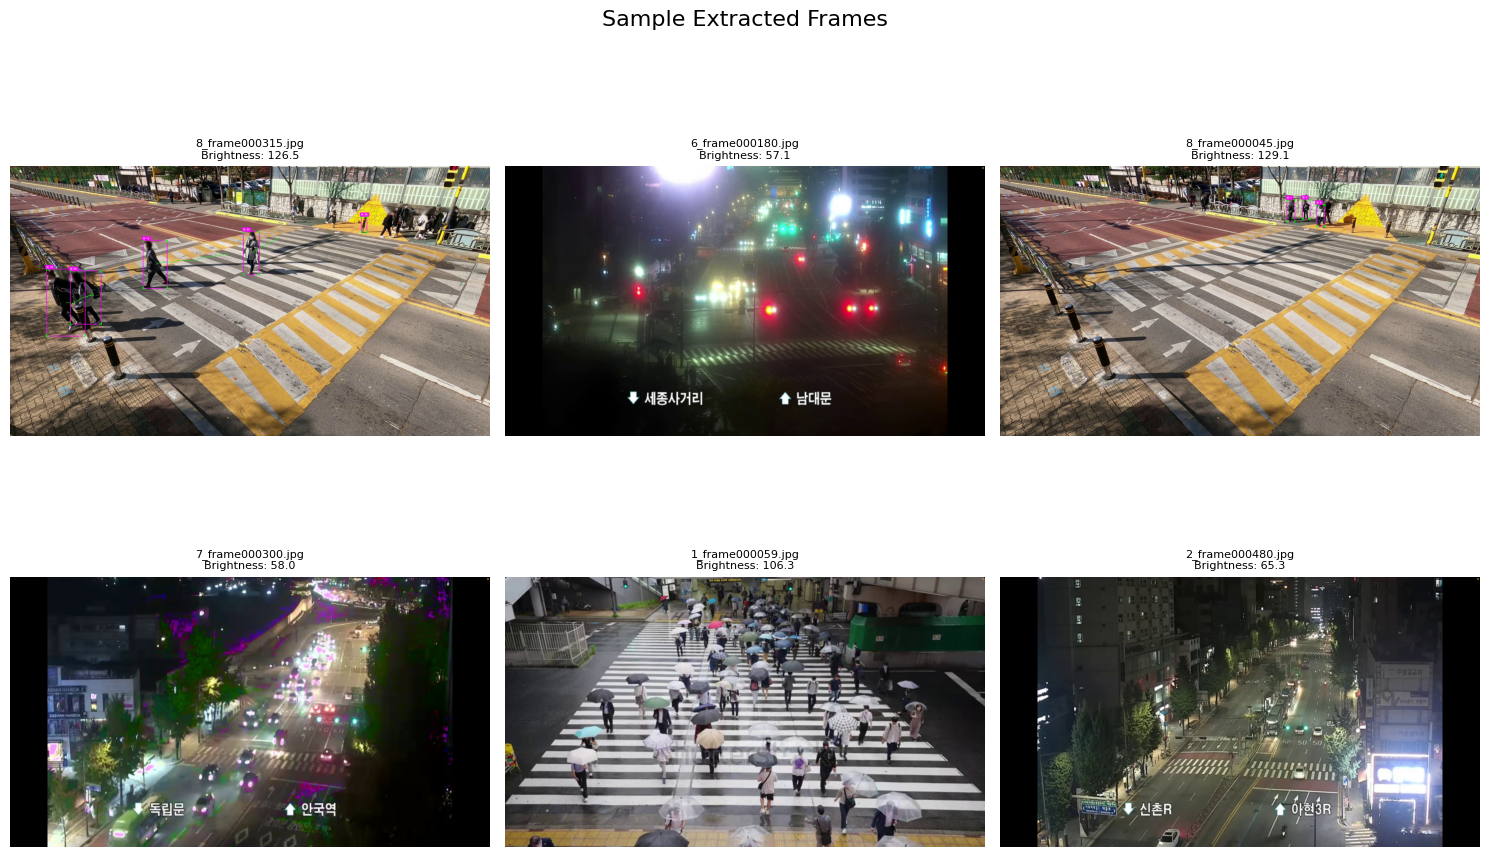

In [11]:
# Cell 7: Visualize - Show sample frames
# Pick 6 random frames to visualize
sample_frames = np.random.choice(frame_files, min(6, len(frame_files)), replace=False)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, frame_path in enumerate(sample_frames):
    # Read image
    img = cv2.imread(str(frame_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for matplotlib
    
    # Calculate brightness
    brightness = np.mean(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY))
    
    # Display
    axes[i].imshow(img)
    axes[i].set_title(f"{frame_path.name}\nBrightness: {brightness:.1f}", fontsize=8)
    axes[i].axis('off')

plt.suptitle('Sample Extracted Frames', fontsize=16)
plt.tight_layout()
plt.show()



Analyzing brightness of all frames...


  0%|          | 0/175 [00:00<?, ?it/s]

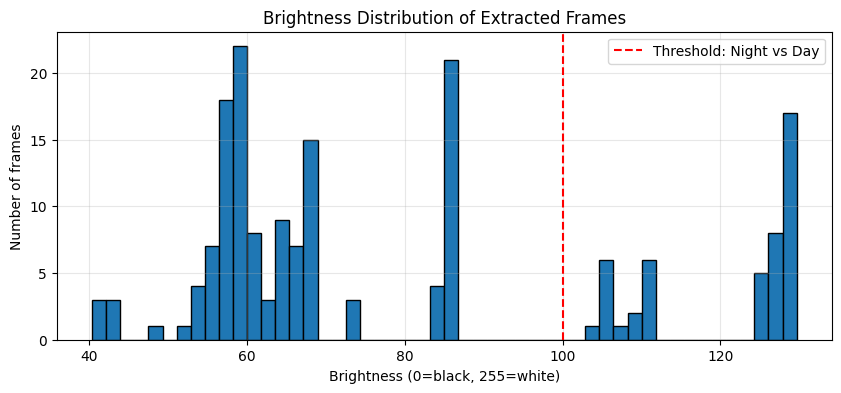


 Frame distribution:
   Night/Dark frames: 129 (73.7%)
    Day/Bright frames: 46 (26.3%)


In [12]:
# Cell 8: OPTIONAL - Check for night vs day frames
# Analyze brightness distribution
brightnesses = []

print("Analyzing brightness of all frames...")
for frame_path in tqdm(frame_files):
    img = cv2.imread(str(frame_path), cv2.IMREAD_GRAYSCALE)
    brightness = np.mean(img)
    brightnesses.append(brightness)

brightnesses = np.array(brightnesses)

# Plot histogram
plt.figure(figsize=(10, 4))
plt.hist(brightnesses, bins=50, edgecolor='black')
plt.axvline(100, color='red', linestyle='--', label='Threshold: Night vs Day')
plt.xlabel('Brightness (0=black, 255=white)')
plt.ylabel('Number of frames')
plt.title('Brightness Distribution of Extracted Frames')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Count night vs day
night_frames = np.sum(brightnesses < 100)
day_frames = np.sum(brightnesses >= 100)

print(f"\n Frame distribution:")
print(f"   Night/Dark frames: {night_frames} ({night_frames/len(brightnesses)*100:.1f}%)")
print(f"    Day/Bright frames: {day_frames} ({day_frames/len(brightnesses)*100:.1f}%)")

In [15]:
# Cell 9: Summary & Next Steps
print("="*60)
print(" SUMMARY")
print("="*60)
print(f" Extracted: {len(frame_files)} frames")
print(f" Output: {output_dir}")
print(f" Videos processed: {len(video_files)}")
print()
print(" NEXT STEPS:")
print("1.  Frames extracted successfully")
print("2.  Next: Prepare FPV dataset (notebook 02)")
print("3.  Then: Visualize both datasets (notebook 03)")
print("4.  Then: Train Stage 1 on FPV (notebook 04)")
print()

print(f"   (Original videos: ~{total_size_mb:.0f} MB)")
print(f"   (Extracted frames: ~{len(frame_files) * 0.5:.0f} MB)")
print(f"   (we saved: ~{total_size_mb - len(frame_files) * 0.5:.0f} MB)")

 SUMMARY
 Extracted: 175 frames
 Output: /data/omar/RESEARCH/crosswalk-cctv/data/cctv_frames
 Videos processed: 8

 NEXT STEPS:
1.  Frames extracted successfully
2.  Next: Prepare FPV dataset (notebook 02)
3.  Then: Visualize both datasets (notebook 03)
4.  Then: Train Stage 1 on FPV (notebook 04)

   (Original videos: ~522 MB)
   (Extracted frames: ~88 MB)
   (we saved: ~434 MB)
